In [127]:
from pathlib import Path
import os
import json
from main import load_data,draw_sample, auc_from_samples, bootstrap
from generate_aggregate_figs import load_results,fit_fig,get_sample_density
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import trange
from scipy.special import rel_entr
from joblib import Parallel, delayed
import scipy.stats as sps

In [2]:
dataset_name = "Giacomelli_p53_wtNutlin3"
results_dir = Path("/data/dzeiberg/mave_calibration/results_08_26_24/")
dataset_dir = Path("/data/dzeiberg/mave_calibration/data/")
with open(dataset_dir / "dataset_configs.json",'r') as f:
    dataset_config = json.load(f)


X,S,sample_names, control_sample_index,mu,sigma = load_data(dataset_id=dataset_name,
                                                            data_directory=dataset_dir,
                                                            **dataset_config[dataset_name],return_standardization=True)
# Load Results
results = load_results(results_dir,dataset_name,lim=10000)

10000it [00:03, 2976.83it/s]


In [159]:
from generate_aggregate_figs import get_priors

In [163]:
get_priors(results,3).mean()

np.float64(0.2945893364811534)

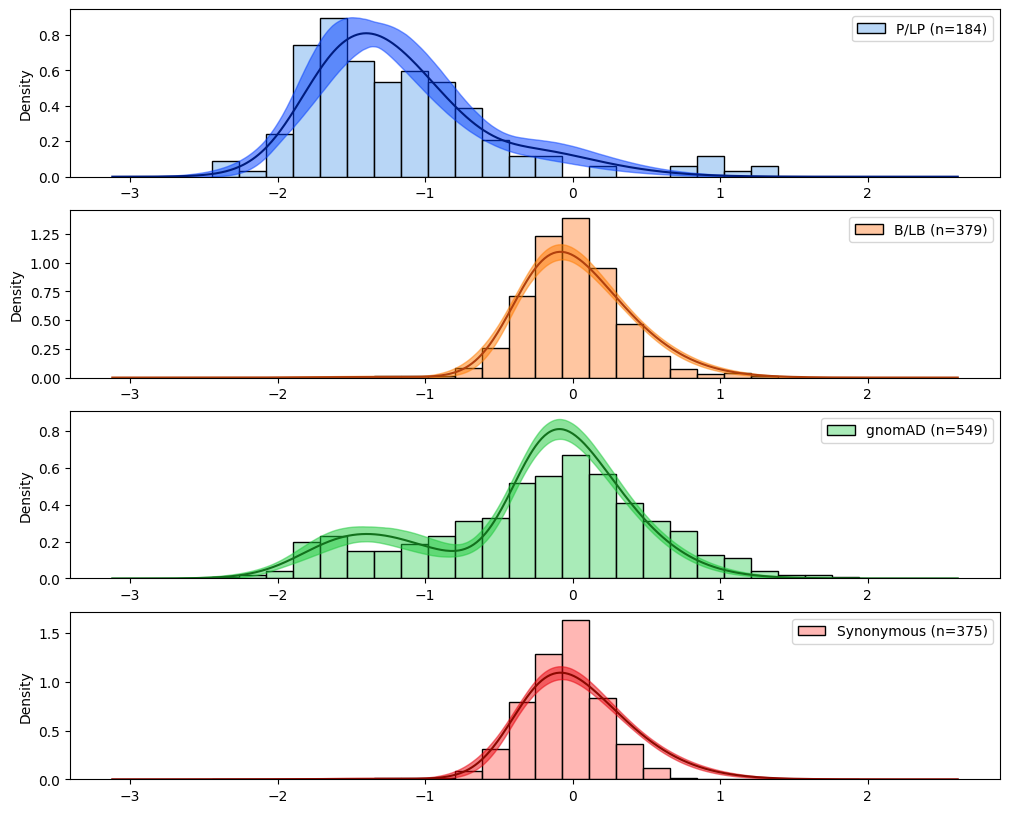

In [4]:
fig,ax = plt.subplots(S.shape[1],1,figsize=(12,2.5*S.shape[1]))
fit_fig(X,S,sample_names,dataset_name,results,ax)

Text(0.5, 0, 'Assay Score')

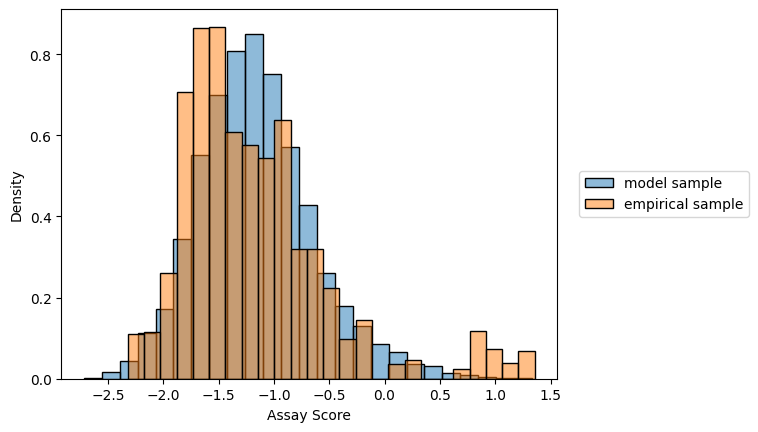

In [16]:
model_sample = draw_sample(results[0]['component_params'], results[0]['weights'][0],N=int(5000))
null_sample = X[np.random.choice(np.where(S[:,0])[0],size=5000,replace=True)]
binkwargs = dict(alpha=.5,stat='density',bins=25)
sns.histplot(model_sample,**binkwargs,label='model sample')
sns.histplot(null_sample,**binkwargs,label='empirical sample')
plt.legend(loc='center right',bbox_to_anchor=(1.4,.5))
plt.xlabel("Assay Score")

In [76]:
def kl_iter(sample_num):
    sample_size = 1000#S[:,sample_num].sum()
    model_sample = np.concatenate([draw_sample(results[result_num]['component_params'], results[result_num]['weights'][sample_num],N=1) \
        for result_num in np.random.choice(len(results),size=sample_size,replace=True)])
    empirical_sample = X[np.random.choice(np.where(S[:,sample_num])[0],size=sample_size,replace=True)]
    null_sample = X[np.random.choice(np.where(S[:,sample_num])[0],size=sample_size,replace=True)]
    _xall = np.concatenate((model_sample, empirical_sample, null_sample))
    bin_edges = np.histogram_bin_edges(_xall,bins='auto',range=(np.min(_xall),np.max(_xall)))
    hist_empirical = np.histogram(empirical_sample,bins=bin_edges,density=True)[0]
    hist_model = np.histogram(model_sample,bins=bin_edges,density=True)[0]
    hist_null = np.histogram(null_sample,bins=bin_edges,density=True)[0]
    kld = rel_entr(hist_empirical,hist_model)
    return  np.ma.masked_invalid(kld).sum(), np.ma.masked_invalid(rel_entr(hist_empirical,hist_null)).sum()

NIters=100
gnomad_kl_results = Parallel(n_jobs=-1,verbose=10)(delayed(kl_iter)(sample_num=2) for result_num in trange(NIters))
pathogenic_kl_results = Parallel(n_jobs=-1,verbose=10)(delayed(kl_iter)(sample_num=0) for result_num in trange(NIters))

  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of 100 | elapsed:    7.1s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  21 out of 100 | elapsed:   12.1s remaining:   45.4s
[Parallel(n_jobs=-1)]: Done  32 out of 100 | elapsed:   17.3s remaining:   36.8s
[Parallel(n_jobs=-1)]: Done  43 out of 100 | elapsed:   22.2s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done  54 out of 100 | elapsed:   27.9s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done  65 out of 100 | elapsed:   32.6s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  76 out of 100 | elapsed:   37.8s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  87 out of 100 | elapsed:   43.0s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:   48.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.9s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of 100 | elapsed:    6.0s remaining:   54.0s
[Parallel(n_jobs=-1)]: Done  21 out of 100 | elapsed:   11.4s remaining:   42.7s
[Parallel(n_jobs=-1)]: Done  32 out of 100 | elapsed:   17.0s remaining:   36.1s
[Parallel(n_jobs=-1)]: Done  43 out of 100 | elapsed:   22.5s remaining:   29.8s
[Parallel(n_jobs=-1)]: Done  54 out of 100 | elapsed:   28.1s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done  65 out of 100 | elapsed:   33.5s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  76 out of 100 | elapsed:   38.8s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  87 out of 100 | elapsed:   44.5s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:   49.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.6s finished


In [77]:
gnomad_empirical, gnomad_null = zip(*gnomad_kl_results)
pathogenic_empirical, pathogenic_null = zip(*pathogenic_kl_results)

Text(0, 0.5, 'Frequency')

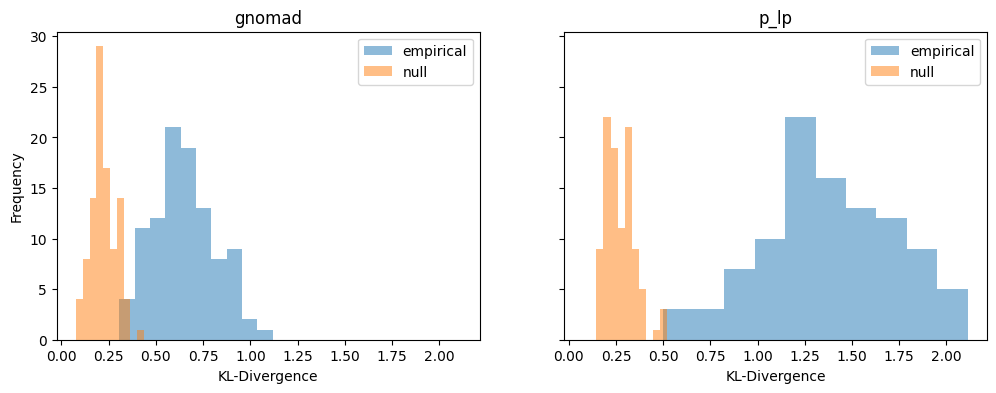

In [78]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharey=True,sharex=True)
ax[0].hist(gnomad_empirical,alpha=.5,label='empirical')
ax[0].hist(gnomad_null,alpha=.5,label='null')
ax[0].set_title(sample_names[2])
ax[0].legend()

ax[1].hist(pathogenic_empirical,alpha=.5,label='empirical')
ax[1].hist(pathogenic_null,alpha=.5,label='null')
ax[1].set_title(sample_names[0])
ax[1].legend()

[axi.set_xlabel("KL-Divergence") for axi in ax]
ax[0].set_ylabel("Frequency")

In [53]:
# empirical_divergences, null_divergences = zip(*kl_results)

In [79]:
from main import singleFit

In [117]:
from main import bootstrap_sample

In [145]:
NFits = 1
RestartsPerIter = 1000
pathogenic_fits = [sorted(Parallel(n_jobs=min(128, RestartsPerIter),verbose=10)(delayed(singleFit)(X[S[:,0]],
                                                                            S[S[:,0]],
                                                                            verbose=False) \
                                                    for i in range(RestartsPerIter)),
                            key=lambda tup: tup[-1][-1])[-1] \
                    for i in trange(NFits)]
gnomad_fits = [sorted(Parallel(n_jobs=min(128, RestartsPerIter),verbose=10)(delayed(singleFit)(X[S[:,2]],
                                                                        S[S[:,2]],
                                                                        verbose=False) \
                                                    for i in range(RestartsPerIter)),
                    key=lambda tup: tup[-1][-1])[-1] \
                    for i in trange(NFits)]

pathogenic_fits = [dict(component_params=pathogenic_fit[0],weights=pathogenic_fit[1],log_likelihood=pathogenic_fit[2],sample_names=sample_names) \
    for pathogenic_fit in pathogenic_fits]
gnomad_fits = [dict(component_params=gnomad_fit[0],weights=gnomad_fit[1],log_likelihood=gnomad_fit[2],sample_names=sample_names) \
    for gnomad_fit in gnomad_fits]

  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
/home/dzeiberg/mave_calibration/mave_calibration/em_opt/utils.py:338: RuntimeWarning: Mean of empty slice.
  ).mean(1)
/home/dzeiberg/.cache/pypoetry/virtualenvs/mave-calibration-xCjwkSk6-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/dzeiberg/mave_calibration/mave_calibration/em_opt/utils.py:338: RuntimeWarning: Mean of empty slice.
  ).mean(1)
/home/dzeiberg/.cache/pypoetry/virtualenvs/mave-calibration-xCjwkSk6-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/dzeiberg/mave_calibration/mave_calibration/em_opt/utils.py:338: RuntimeWarning: Mean of empty slice.
  ).mean(1)
/home/dzeiberg/.cache/pypoetry/virtualenvs/mave-calibration-xCjwkSk6-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWar

  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
/home/dzeiberg/mave_calibration/mave_calibration/em_opt/utils.py:338: RuntimeWarning: Mean of empty slice.
  ).mean(1)
/home/dzeiberg/.cache/pypoetry/virtualenvs/mave-calibration-xCjwkSk6-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/dzeiberg/mave_calibration/mave_calibration/em_opt/utils.py:338: RuntimeWarning: Mean of empty slice.
  ).mean(1)
/home/dzeiberg/.cache/pypoetry/virtualenvs/mave-calibration-xCjwkSk6-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/dzeiberg/mave_calibration/mave_calibration/em_opt/utils.py:338: RuntimeWarning: Mean of empty slice.
  ).mean(1)
/home/dzeiberg/.cache/pypoetry/virtualenvs/mave-calibration-xCjwkSk6-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWar

In [146]:
rng = np.arange(X.min() - X.std() , X.max() + X.std(),.01)

D_pathogenic = get_sample_density(rng, pathogenic_fits)
D_gnomad = get_sample_density(rng, gnomad_fits)
DM = get_sample_density(rng, results)

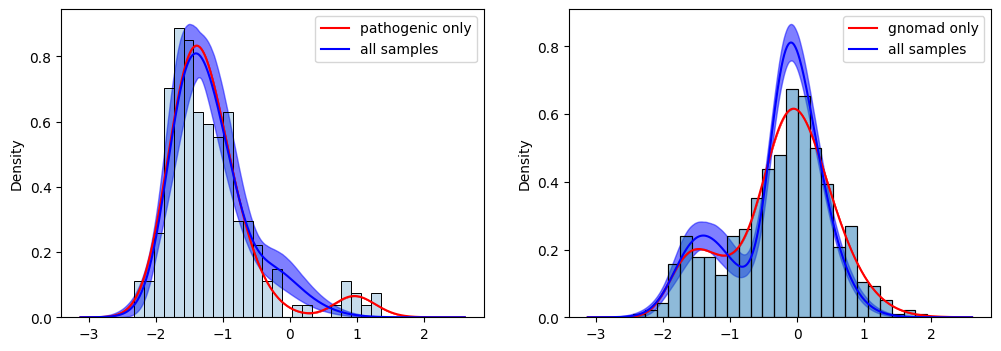

In [147]:

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(rng,D_pathogenic[0].mean(0),label='pathogenic only',color='red')
ax[0].fill_between(rng,*np.quantile(D_pathogenic[0],(0.025,0.975),axis=0),alpha=.5,color='red')

ax[0].plot(rng,DM[0].mean(0),label='all samples',color='blue')
ax[0].fill_between(rng,*np.quantile(DM[0],(0.025,0.975),axis=0),alpha=.5,color='blue')

ax[0].legend()
sns.histplot(X[S[:,0]],stat='density',bins=25,alpha=.25,ax=ax[0])


ax[1].plot(rng,D_gnomad[2].mean(0),label='gnomad only',color='red')
ax[1].fill_between(rng,*np.quantile(D_gnomad[2],(0.025,0.975),axis=0),alpha=.5,color='red')
ax[1].plot(rng,DM[2].mean(0),label='all samples',color='blue')
ax[1].fill_between(rng,*np.quantile(DM[2],(0.025,0.975),axis=0),alpha=.5,color='blue')
sns.histplot(X[S[:,2]],stat='density',bins=25,alpha=.5,ax=ax[1])
ax[1].legend()

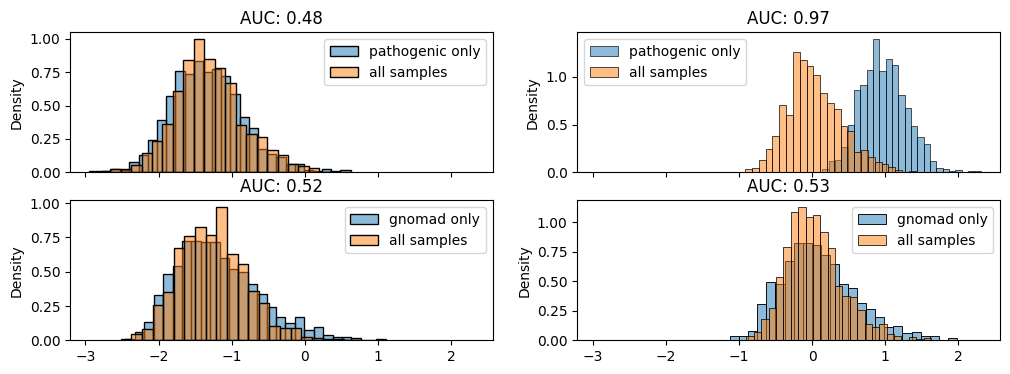

In [158]:
fig,(ax,bx) = plt.subplots(2,2,figsize=(12,4),sharex=True)
for comp_num in range(2):
    # draw 1000 observations from the models fit to pathogenic sample only
    pathogenic_functional_sample_empirical = np.concatenate([sps.skewnorm.rvs(*pathogenic_fits[model_num]['component_params'][comp_num],size=1) \
    for model_num in np.random.choice(len(pathogenic_fits),size=1000,replace=True)])
    # draw 1000 observations from the models fit to all samples (each sampled from a random model out of the 10k fits)
    pathogenic_functional_sample_single = np.concatenate([sps.skewnorm.rvs(*results[model_num]['component_params'][comp_num],size=1) \
        for model_num in np.random.choice(len(results),size=1000,replace=True)])
    # plot the histograms
    sns.histplot(pathogenic_functional_sample_empirical,stat='density',bins=25,alpha=.5,label='pathogenic only',ax=ax[comp_num])
    sns.histplot(pathogenic_functional_sample_single,stat='density',bins=25,alpha=.5,label='all samples',ax=ax[comp_num])
    # Calculate AUC between the two samples estimated to represent the 
    auc = auc_from_samples(pathogenic_functional_sample_single,pathogenic_functional_sample_empirical)
    ax[comp_num].set_title(f"AUC: {auc:.2f}")
    ax[comp_num].legend()

    gnomad_functional_sample_empirical = np.concatenate([sps.skewnorm.rvs(*gnomad_fits[model_num]['component_params'][comp_num],size=1) \
    for model_num in np.random.choice(len(gnomad_fits),size=1000,replace=True)])
    gnomad_functional_sample_single = np.concatenate([sps.skewnorm.rvs(*results[model_num]['component_params'][comp_num],size=1) \
        for model_num in np.random.choice(len(results),size=1000,replace=True)])
    sns.histplot(gnomad_functional_sample_empirical,stat='density',bins=25,alpha=.5,label='gnomad only',ax=bx[comp_num])
    sns.histplot(gnomad_functional_sample_single,stat='density',bins=25,alpha=.5,label='all samples',ax=bx[comp_num])
    auc = auc_from_samples(gnomad_functional_sample_single,gnomad_functional_sample_empirical)
    bx[comp_num].set_title(f"AUC: {auc:.2f}")
    bx[comp_num].legend()